In [1]:
## Installing yahoo finance
!pip install yfinance
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from pmdarima import auto_arima
import pmdarima as pm
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
#Data collecting from yahoo finance
df_tesla = yf.download('TSLA', start= '2019-01-01', end='2024-09-30')

[*********************100%***********************]  1 of 1 completed


In [4]:
df_tesla.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-01-02,20.674667,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03,20.024000,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04,21.179333,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07,22.330667,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08,22.356667,22.356667,22.934000,21.801332,22.797333,105127500


<Axes: xlabel='Date'>

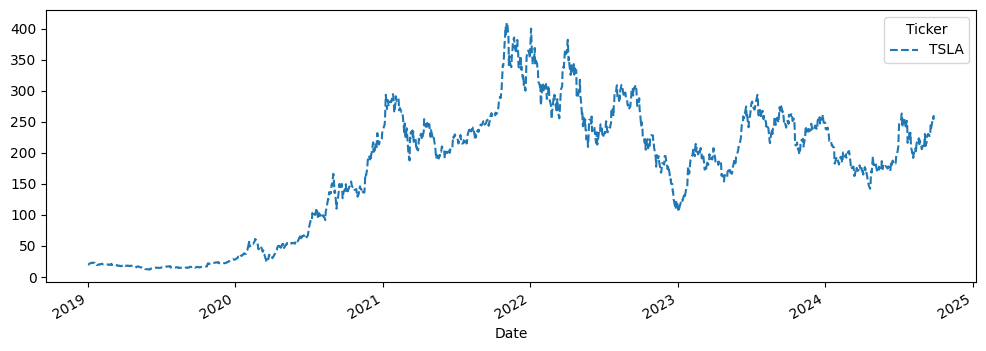

In [5]:
df_tesla['Close'].plot(figsize=(12,4), linestyle='--')

In [6]:
## Datetime Index
df_tesla.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=1445, freq=None)

In [7]:
df_tesla.index = pd.to_datetime(df_tesla.index)

Data preprocessing

In [8]:
df_tesla_resam = df_tesla.resample(rule='M').mean()

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_tesla_resam['Close'].values.reshape(-1,1))

In [41]:
# # Data preprocessing for LSTM
# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(df_tesla_resam['Close'].values.reshape(-1,1))

In [42]:
# Splitting data into train and test - assuming 80/20
train_size_lstm = int(len(data_scaled) * 0.8)
#test_size_lstm = len(data_scaled) - train_size_lstm
train_lstm, test_lstm = data_scaled[0:train_size_lstm, :], data_scaled[train_size_lstm:len(data_scaled), :]

In [43]:
# Convert an array of values into a dataset matrix
def prepare_data(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [44]:
# Reshape into X=t and Y=t+1
time_steps = 1
trainX, trainY = prepare_data(train_lstm, time_steps)
testX, testY = prepare_data(test_lstm, time_steps)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(1, time_steps)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
53/53 - 4s - 77ms/step - loss: 1.5924
Epoch 2/50
53/53 - 0s - 3ms/step - loss: 1.5006
Epoch 3/50
53/53 - 0s - 2ms/step - loss: 1.4228
Epoch 4/50
53/53 - 0s - 3ms/step - loss: 1.3611
Epoch 5/50
53/53 - 0s - 3ms/step - loss: 1.3035
Epoch 6/50
53/53 - 0s - 3ms/step - loss: 1.2507
Epoch 7/50
53/53 - 0s - 2ms/step - loss: 1.1947
Epoch 8/50
53/53 - 0s - 2ms/step - loss: 1.1304
Epoch 9/50
53/53 - 0s - 2ms/step - loss: 1.0494
Epoch 10/50
53/53 - 0s - 2ms/step - loss: 0.9518
Epoch 11/50
53/53 - 0s - 2ms/step - loss: 0.8383
Epoch 12/50
53/53 - 0s - 2ms/step - loss: 0.7181
Epoch 13/50
53/53 - 0s - 2ms/step - loss: 0.5999
Epoch 14/50
53/53 - 0s - 2ms/step - loss: 0.4898
Epoch 15/50
53/53 - 0s - 2ms/step - loss: 0.3962
Epoch 16/50
53/53 - 0s - 2ms/step - loss: 0.3139
Epoch 17/50
53/53 - 0s - 2ms/step - loss: 0.2504
Epoch 18/50
53/53 - 0s - 3ms/step - loss: 0.2041
Epoch 19/50
53/53 - 0s - 3ms/step - loss: 0.1671
Epoch 20/50
53/53 - 0s - 2ms/step - loss: 0.1421
Epoch 21/50
53/53 - 0s - 2ms

In [46]:
# Invert predictions
trainPredict = scaler.inverse_transform(model_lstm.predict(trainX))
testPredict = scaler.inverse_transform(model_lstm.predict(testX))
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [47]:
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict

In [48]:
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(data_scaled)-1, :] = testPredict

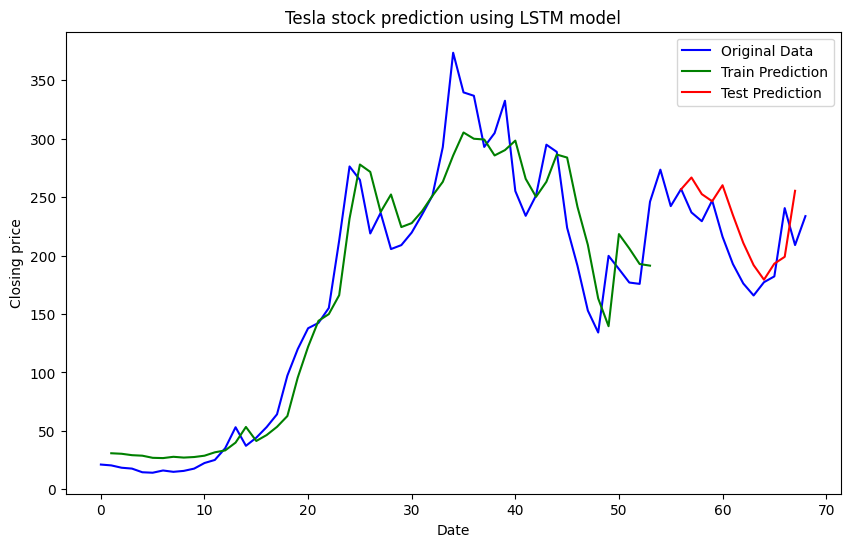

In [49]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_scaled), label='Original Data', color='blue')
plt.plot(trainPredictPlot, label='Train Prediction', color='green')
plt.plot(testPredictPlot, label='Test Prediction', color='red')
plt.title('Tesla stock prediction using LSTM model')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend()
plt.show()